# Plotting the distribution of the tumor cell population and fraction

## Import libraries

In [3]:
# %matplotlib notebook
#  add Python-loader repo to the path 
import sys
sys.path.insert(0, '../Python-loader/')
from pyMCDS import pyMCDS

import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.integrate import odeint

## Define cell cycle model

In [4]:
# CELL CYCLE MODELS
### advanced_Ki67_cycle_model = 0
### basic_Ki67_cycle_model = 1
### flow_cytometry_cycle_model = 2
### live_apoptotic_cycle_model = 3
### total_cells_cycle_model = 4
### live_cells_cycle_model = 5 
### flow_cytometry_separated_cycle_model = 6
### cycling_quiescent_model = 7
cycle_model = 0

# output_folder = "output_Live_dt6_NC100_R100/"
# output_folder = "output_Ki67_Basic_dt6_NC100_R100/"
output_folder = "output_Ki67_Advanced_dt6_NC100_R200/"
# output_folder = "output_Flow_Cytometry_dt6_NC100_R100/"
# output_folder = "output_Separated_Flow_Cytometry_dt6_NC100_R100/"

## List output folders

In [5]:
## Type pyMCDS. and hit the tab key to see methods 

sorted(os.listdir("./"+output_folder))

['output_R00',
 'output_R01',
 'output_R02',
 'output_R03',
 'output_R04',
 'output_R05',
 'output_R06',
 'output_R07',
 'output_R08',
 'output_R09',
 'output_R10',
 'output_R100',
 'output_R101',
 'output_R102',
 'output_R103',
 'output_R104',
 'output_R105',
 'output_R106',
 'output_R107',
 'output_R108',
 'output_R109',
 'output_R11',
 'output_R110',
 'output_R111',
 'output_R112',
 'output_R113',
 'output_R114',
 'output_R115',
 'output_R116',
 'output_R117',
 'output_R118',
 'output_R119',
 'output_R12',
 'output_R120',
 'output_R121',
 'output_R122',
 'output_R123',
 'output_R124',
 'output_R125',
 'output_R126',
 'output_R127',
 'output_R128',
 'output_R129',
 'output_R13',
 'output_R130',
 'output_R131',
 'output_R132',
 'output_R133',
 'output_R134',
 'output_R135',
 'output_R136',
 'output_R137',
 'output_R138',
 'output_R139',
 'output_R14',
 'output_R140',
 'output_R141',
 'output_R142',
 'output_R143',
 'output_R144',
 'output_R145',
 'output_R146',
 'output_R147',
 'outpu

## List *.xml* output files from one replicate

In [6]:
## Type pyMCDS. and hit the tab key to see methods 

file_list = []
for file in os.listdir("./"+output_folder+"output_R00/"):
    if file.endswith(".xml"):
        file_list.append(os.path.join("./"+output_folder+"output_R00/", file))
print(sorted(file_list))

['./output_Ki67_Advanced_dt6_NC100_R200/output_R00/PhysiCell_settings_Ki67_Advanced_without_o2_apop_nec.xml', './output_Ki67_Advanced_dt6_NC100_R200/output_R00/final.xml', './output_Ki67_Advanced_dt6_NC100_R200/output_R00/initial.xml']


## Compute the number of each tumor cell phenotype over all replicates and simulation times

In [7]:
# num_replicates = 10;
# last_index = 120;

# times = np.zeros( last_index+1 ); 
# if cycle_model == 0:
#     Ki67_negative_count = np.zeros( (num_replicates, last_index+1) ); 
#     Ki67_positive_premitotic_count = np.zeros( (num_replicates, last_index+1) ); 
#     Ki67_positive_postmitotic_count = np.zeros( (num_replicates, last_index+1) ); 
# elif cycle_model == 1:
#     Ki67_negative_count = np.zeros( (num_replicates, last_index+1) ); 
#     Ki67_positive_count = np.zeros( (num_replicates, last_index+1) ); 
# elif cycle_model == 2:
#     G0G1_phase_count = np.zeros( (num_replicates, last_index+1) ); 
#     S_phase_count = np.zeros( (num_replicates, last_index+1) ); 
#     G2M_phase_count = np.zeros( (num_replicates, last_index+1) ); 
# elif cycle_model == 5:
#     live_count = np.zeros( (num_replicates, last_index+1) ); 
# elif cycle_model == 6:
#     G0G1_phase_count = np.zeros( (num_replicates, last_index+1) ); 
#     S_phase_count = np.zeros( (num_replicates, last_index+1) ); 
#     G2_phase_count = np.zeros( (num_replicates, last_index+1) ); 
#     M_phase_count = np.zeros( (num_replicates, last_index+1) ); 
# else:
#     print("Unrecognized cell cycle model.")
# apoptotic_count = np.zeros( (num_replicates, last_index+1) ); 
# necrotic_count = np.zeros( (num_replicates, last_index+1) ); 

# for id_replicate in range(num_replicates):
#     folder_name = output_folder+"output_R"+str("%02d"%id_replicate)+'/'
#     for n in range( 0, last_index+1 ):
#         filename = 'output'+"%08i"%n+'.xml'
#         mcds = pyMCDS(filename, folder_name)

#         times[n] = mcds.get_time()
#         cp = mcds.data['discrete_cells']['current_phase']
#         if cycle_model == 0:
#             Ki67_negative = np.argwhere( cp == 3 ).flatten()
#             Ki67_positive_premitotic = np.argwhere( cp == 0 ).flatten()
#             Ki67_positive_postmitotic = np.argwhere( cp == 1 ).flatten()

#             Ki67_negative_count[id_replicate][n] = len( Ki67_negative )
#             Ki67_positive_premitotic_count[id_replicate][n] = len( Ki67_positive_premitotic )
#             Ki67_positive_postmitotic_count[id_replicate][n] = len( Ki67_positive_postmitotic )
#         elif cycle_model == 1:
#             Ki67_negative = np.argwhere( cp == 3 ).flatten()
#             Ki67_positive = np.argwhere( cp == 2 ).flatten()

#             Ki67_negative_count[id_replicate][n] = len( Ki67_negative )
#             Ki67_positive_count[id_replicate][n] = len( Ki67_positive )
#         elif cycle_model == 2:
#             G0G1_phase = np.argwhere( cp == 4 ).flatten()
#             S_phase = np.argwhere( cp == 10 ).flatten()
#             G2M_phase = np.argwhere( cp == 11 ).flatten()

#             G0G1_phase_count[id_replicate][n] = len( G0G1_phase )
#             S_phase_count[id_replicate][n] = len( S_phase )
#             G2M_phase_count[id_replicate][n] = len( G2M_phase )
#         elif cycle_model == 5:
#             live = np.argwhere( cp == 14 ).flatten()

#             live_count[id_replicate][n] = len( live )
#         elif cycle_model == 6:
#             G0G1_phase = np.argwhere( cp == 4 ).flatten()
#             S_phase = np.argwhere( cp == 10 ).flatten()
#             G2_phase = np.argwhere( cp == 12 ).flatten()
#             M_phase = np.argwhere( cp == 13 ).flatten()

#             G0G1_phase_count[id_replicate][n] = len( G0G1_phase )
#             S_phase_count[id_replicate][n] = len( S_phase )
#             G2_phase_count[id_replicate][n] = len( G2_phase )
#             M_phase_count[id_replicate][n] = len( M_phase )
#         else:
#             print("Unrecognized cell cycle model.")
#         apoptotic = np.argwhere( cp == 100 ).flatten()
#         necrotic = np.argwhere( cp == 103 ).flatten()

#         apoptotic_count[id_replicate][n] = len( apoptotic )
#         necrotic_count[id_replicate][n] = len( necrotic )

In [8]:
num_replicates = 200;
last_index = 120;
filename = "PhysiCell_tumor_cell_population.csv";

times = np.zeros( last_index+1 ); 
if cycle_model == 0:
    Ki67_negative_count = np.zeros( (num_replicates, last_index+1) ); 
    Ki67_positive_premitotic_count = np.zeros( (num_replicates, last_index+1) ); 
    Ki67_positive_postmitotic_count = np.zeros( (num_replicates, last_index+1) ); 
elif cycle_model == 1:
    Ki67_negative_count = np.zeros( (num_replicates, last_index+1) ); 
    Ki67_positive_count = np.zeros( (num_replicates, last_index+1) ); 
elif cycle_model == 2:
    G0G1_phase_count = np.zeros( (num_replicates, last_index+1) ); 
    S_phase_count = np.zeros( (num_replicates, last_index+1) ); 
    G2M_phase_count = np.zeros( (num_replicates, last_index+1) ); 
elif cycle_model == 5:
    live_count = np.zeros( (num_replicates, last_index+1) ); 
elif cycle_model == 6:
    G0G1_phase_count = np.zeros( (num_replicates, last_index+1) ); 
    S_phase_count = np.zeros( (num_replicates, last_index+1) ); 
    G2_phase_count = np.zeros( (num_replicates, last_index+1) ); 
    M_phase_count = np.zeros( (num_replicates, last_index+1) ); 
else:
    print("Unrecognized cell cycle model.")
dead_count = np.zeros( (num_replicates, last_index+1) ); 

for id_replicate in range(num_replicates):
    folder_name = output_folder+"output_R"+str("%02d"%id_replicate)+'/'
    
    data = np.genfromtxt(folder_name + filename, dtype = float, delimiter = ',', names = True)
    times[:] = data["times"]
    if cycle_model == 0:
        Ki67_negative_count[id_replicate,:] = data["Ki67_negative_num"]
        Ki67_positive_premitotic_count[id_replicate,:] = data["Ki67_positive_premitotic_num"]
        Ki67_positive_postmitotic_count[id_replicate,:] = data["Ki67_positive_postmitotic_num"]
    elif cycle_model == 1:
        Ki67_negative_count[id_replicate,:] = data["Ki67_negative_num"]
        Ki67_positive_count[id_replicate,:] = data["Ki67_positive_num"]
    elif cycle_model == 2:
        G0G1_phase_count[id_replicate,:] = data["G0G1_phase_num"]
        S_phase_count[id_replicate,:] = data["S_phase_num"]
        G2M_phase_count[id_replicate,:] = data["G2M_phase_num"]
    elif cycle_model == 5:
        live_count[id_replicate,:] = data["live_num"]
    elif cycle_model == 6:
        G0G1_phase_count[id_replicate,:] = data["G0G1_phase_num"]
        S_phase_count[id_replicate,:] = data["S_phase_num"]
        G2_phase_count[id_replicate,:] = data["G2_phase_num"]
        M_phase_count[id_replicate,:] = data["M_phase_num"]
    else:
        print("Unrecognized cell cycle model.")
    dead_count[id_replicate,:] = data["Dead_num"]

## Compute tumor cell fraction over all replicates and simulation times

In [9]:
if cycle_model == 0:
    Ki67_negative_fraction = np.zeros( (num_replicates, last_index+1) ); 
    Ki67_positive_premitotic_fraction = np.zeros( (num_replicates, last_index+1) ); 
    Ki67_positive_postmitotic_fraction = np.zeros( (num_replicates, last_index+1) ); 
elif cycle_model == 1:
    Ki67_negative_fraction = np.zeros( (num_replicates, last_index+1) ); 
    Ki67_positive_fraction = np.zeros( (num_replicates, last_index+1) ); 
elif cycle_model == 2:
    G0G1_phase_fraction = np.zeros( (num_replicates, last_index+1) ); 
    S_phase_fraction = np.zeros( (num_replicates, last_index+1) ); 
    G2M_phase_fraction = np.zeros( (num_replicates, last_index+1) ); 
elif cycle_model == 5:
    live_fraction = np.zeros( (num_replicates, last_index+1) ); 
elif cycle_model == 6:
    G0G1_phase_fraction = np.zeros( (num_replicates, last_index+1) ); 
    S_phase_fraction = np.zeros( (num_replicates, last_index+1) ); 
    G2_phase_fraction = np.zeros( (num_replicates, last_index+1) ); 
    M_phase_fraction = np.zeros( (num_replicates, last_index+1) ); 
else:
    print("Unrecognized cell cycle model.")
# apoptotic_fraction = np.zeros( (num_replicates, last_index+1) ); 
# necrotic_fraction = np.zeros( (num_replicates, last_index+1) ); 
dead_fraction = np.zeros( (num_replicates, last_index+1) ); 

for id_replicate in range(num_replicates):
    if cycle_model == 0:
        total_count = Ki67_negative_count[id_replicate,:] + Ki67_positive_premitotic_count[id_replicate,:] + Ki67_positive_postmitotic_count[id_replicate,:];
        # total_count += apoptotic_count[id_replicate,:] + necrotic_count[id_replicate,:];
        total_count += dead_count[id_replicate,:];

        Ki67_negative_fraction[id_replicate,:] = Ki67_negative_count[id_replicate,:]/total_count;
        Ki67_positive_premitotic_fraction[id_replicate,:] = Ki67_positive_premitotic_count[id_replicate,:]/total_count;
        Ki67_positive_postmitotic_fraction[id_replicate,:] = Ki67_positive_postmitotic_count[id_replicate,:]/total_count;
    elif cycle_model == 1:
        total_count = Ki67_negative_count[id_replicate,:] + Ki67_positive_count[id_replicate,:];
        # total_count += apoptotic_count[id_replicate,:] + necrotic_count[id_replicate,:];
        total_count += dead_count[id_replicate,:];

        Ki67_negative_fraction[id_replicate,:] = Ki67_negative_count[id_replicate,:]/total_count;
        Ki67_positive_fraction[id_replicate,:] = Ki67_positive_count[id_replicate,:]/total_count;
    elif cycle_model == 2:
        total_count = G0G1_phase_count[id_replicate,:] + S_phase_count[id_replicate,:] + G2M_phase_count[id_replicate,:];
        # total_count += apoptotic_count[id_replicate,:] + necrotic_count[id_replicate,:];
        total_count += dead_count[id_replicate,:];

        G0G1_phase_fraction[id_replicate,:] = G0G1_phase_count[id_replicate,:]/total_count;
        S_phase_fraction[id_replicate,:] = S_phase_count[id_replicate,:]/total_count;
        G2M_phase_fraction[id_replicate,:] = G2M_phase_count[id_replicate,:]/total_count;
    elif cycle_model == 5:
        total_count = live_count[id_replicate,:];
        # total_count += apoptotic_count[id_replicate,:] + necrotic_count[id_replicate,:];
        total_count += dead_count[id_replicate,:];

        live_fraction[id_replicate,:] = live_count[id_replicate,:]/total_count;
    elif cycle_model == 6:
        total_count = G0G1_phase_count[id_replicate,:] + S_phase_count[id_replicate,:] + G2_phase_count[id_replicate,:] + M_phase_count[id_replicate,:];
        # total_count += apoptotic_count[id_replicate,:] + necrotic_count[id_replicate,:];
        total_count += dead_count[id_replicate,:];

        G0G1_phase_fraction[id_replicate,:] = G0G1_phase_count[id_replicate,:]/total_count;
        S_phase_fraction[id_replicate,:] = S_phase_count[id_replicate,:]/total_count;
        G2_phase_fraction[id_replicate,:] = G2_phase_count[id_replicate,:]/total_count;
        M_phase_fraction[id_replicate,:] = M_phase_count[id_replicate,:]/total_count;
    else:
        print("Unrecognized cell cycle model.")
    # apoptotic_fraction[id_replicate,:] = apoptotic_count[id_replicate,:]/total_count;
    # necrotic_fraction[id_replicate,:] = necrotic_count[id_replicate,:]/total_count;
    dead_fraction[id_replicate,:] = dead_count[id_replicate,:]/total_count;

## Solve true model numerically

In [10]:
number_of_cells = 100

if cycle_model == 0:
    def true_model(X, t, r01, r10, r12, r20):
        Ki67_neg, Ki67_pos_pre, Ki67_pos_post = X
        dXdt = [-r01*Ki67_neg + r10*Ki67_pos_post,
            r01*Ki67_neg - r12*Ki67_pos_pre,
            2.0*r12*Ki67_pos_pre - r20*Ki67_pos_post
        ]
        return dXdt
    
    X0 = np.array([number_of_cells, 0, 0])
    r01 = 0.004604052
    r10 = 0.006666667
    r12 = 0.001282051
    r20 = 0.006666667
    true_solution = odeint(true_model, X0, times, args=(r01, r10, r12, r20))
elif cycle_model == 1:
    def true_model(X, t, r01, r10):
        Ki67_neg, Ki67_pos = X
        dXdt = [-r01*Ki67_neg + 2.0*r10*Ki67_pos, 
            r01*Ki67_neg - r10*Ki67_pos
        ]
        return dXdt
    
    X0 = np.array([number_of_cells, 0])
    r01 = 0.003631082
    r10 = 0.001075269
    true_solution = odeint(true_model, X0, times, args=(r01, r10))
elif cycle_model == 2:
    def true_model(X, t, r01, r20, r12):
        G0G1, S, G2M = X
        dXdt = [-r01*G0G1 + 2.0*r20*G2M,
            r01*G0G1 - r12*S,
            r12*S - r20*G2M
        ]
        return dXdt
    
    X0 = np.array([number_of_cells, 0, 0])
    r01 = 0.003236246
    r20 = 0.003333333
    r12 = 0.002083333
    true_solution = odeint(true_model, X0, times, args=(r01, r20, r12))
elif cycle_model == 5:
    def true_model(X, t, b):
        live = X
        dXdt = b*live
        return dXdt
    
    X0 = np.array([number_of_cells])
    b = 0.0007198228
    true_solution = odeint(true_model, X0, times, args=(b,))
elif cycle_model == 6:
    def true_model(X, t, r01, r30, r12, r23):
        G0G1, S, G2, M = X
        dXdt = [-r01*G0G1 + 2.0*r30*M,
            r01*G0G1 - r12*S,
            r12*S - r23*G2,
            r23*G2 - r30*M
        ]
        return dXdt
    
    X0 = np.array([number_of_cells, 0, 0, 0])
    r01 = 0.00334672
    r30 = 0.016666667
    r12 = 0.002083333
    r23 = 0.004166667
    true_solution = odeint(true_model, X0, times, args=(r01, r30, r12, r23))
else:
    print("Unrecognized cell cycle model.")

## Compute tumor cell fraction for the true model

In [11]:
total_true = np.sum(true_solution, axis=1)

if cycle_model == 0:
    Ki67_negative_true = true_solution[:,0]/total_true;
    Ki67_positive_premitotic_true = true_solution[:,1]/total_true;
    Ki67_positive_postmitotic_true = true_solution[:,2]/total_true;
elif cycle_model == 1:
    Ki67_negative_true = true_solution[:,0]/total_true;
    Ki67_positive_true = true_solution[:,1]/total_true;
elif cycle_model == 2:
    G0G1_phase_true = true_solution[:,0]/total_true;
    S_phase_true = true_solution[:,1]/total_true;
    G2M_phase_true = true_solution[:,2]/total_true;
elif cycle_model == 5:
    live_true = true_solution[:,0]/total_true;
elif cycle_model == 6:
    G0G1_phase_true = true_solution[:,0]/total_true;
    S_phase_true = true_solution[:,1]/total_true;
    G2_phase_true = true_solution[:,2]/total_true;
    M_phase_true = true_solution[:,3]/total_true;
else:
    print("Unrecognized cell cycle model.")

## Plot the distribution of the tumor cell population at the final simulation time

In [18]:
def plot_distribution(data, true, cell_cycle_phase_title, cell_cycle_phase_filename, bins = 40):
    plt.clf()
    plt.subplots(1, 1, figsize = (5.27, 2.96), dpi = 300)
    plt.hist(data, bins=bins, edgecolor = 'gray', facecolor='blue', alpha=0.4)
    plt.axvline(np.mean(data), label = "Mean", color="tab:gray", linestyle=':')
    plt.axvline(true, label = "True", color='tab:red', linestyle=':')
    plt.legend()
    
    # plt.title( 'Distribution of the ' + cell_cycle_phase_title, size=20)
    plt.xlabel( cell_cycle_phase_title, size=15 ) 
    plt.ylabel( 'Frequency', size=15 )
    plt.savefig(os.path.join(output_folder, cell_cycle_phase_filename + "_hist" + str(bins) + ".pdf"), bbox_inches = 'tight')

<Figure size 432x288 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

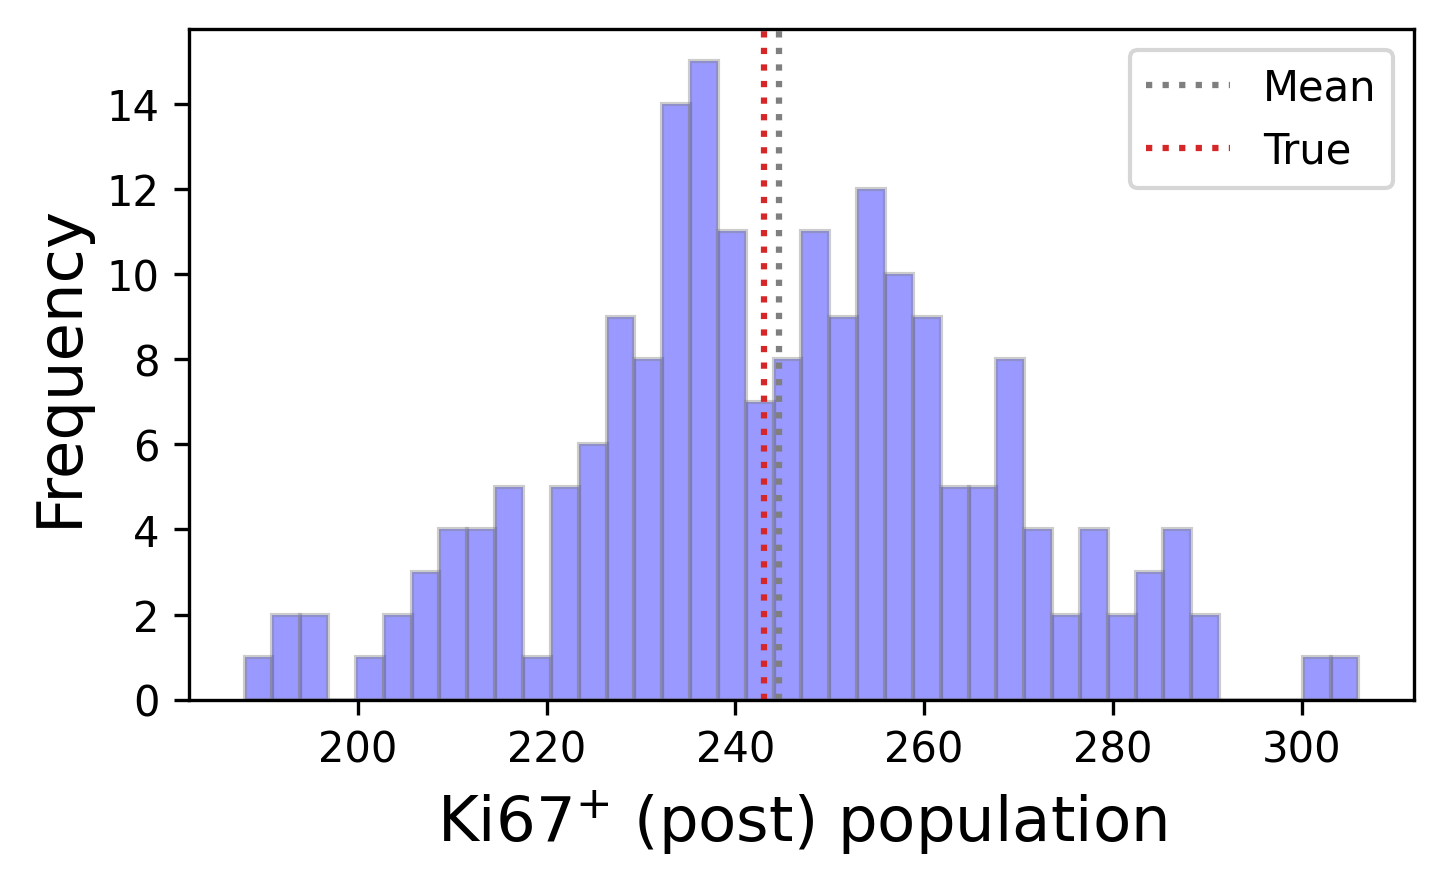

In [19]:
if cycle_model == 0:
    plot_distribution(Ki67_negative_count[:,-1], true_solution[-1,0], r"Ki67$^{-}$ population", "Ki67_neg_pop")
    plot_distribution(Ki67_positive_premitotic_count[:,-1], true_solution[-1,1], r"Ki67$^{+}$ (pre) population", "Ki67_pos_pre_pop")
    plot_distribution(Ki67_positive_postmitotic_count[:,-1], true_solution[-1,2], r"Ki67$^{+}$ (post) population", "Ki67_pos_post_pop")
elif cycle_model == 1:
    plot_distribution(Ki67_negative_count[:,-1], true_solution[-1,0], r"Ki67$^{-}$ population", "Ki67_neg_pop")
    plot_distribution(Ki67_positive_count[:,-1], true_solution[-1,1], r"Ki67$^{+}$ population", "Ki67_pos_pop")
elif cycle_model == 2:
    plot_distribution(G0G1_phase_count[:,-1], true_solution[-1,0], r"G0/G1 population", "G0G1_phase_pop")
    plot_distribution(S_phase_count[:,-1], true_solution[-1,1], r"S population", "S_phase_pop")
    plot_distribution(G2M_phase_count[:,-1], true_solution[-1,2], r"G2/M population", "G2M_phase_pop")
elif cycle_model == 5:
    plot_distribution(live_count[:,-1], true_solution[-1,0], r"Live population", "Live_pop")
elif cycle_model == 6:
    plot_distribution(G0G1_phase_count[:,-1], true_solution[-1,0], r"G0/G1 population", "G0G1_phase_pop")
    plot_distribution(S_phase_count[:,-1], true_solution[-1,1], r"S population", "S_phase_pop")
    plot_distribution(G2_phase_count[:,-1], true_solution[-1,2], r"G2 population", "G2_phase_pop")
    plot_distribution(M_phase_count[:,-1], true_solution[-1,3], r"M population", "M_phase_pop")
else:
    print("Unrecognized cell cycle model.")

## Plot the distribution of the tumor cell fraction at the final simulation time

<Figure size 432x288 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

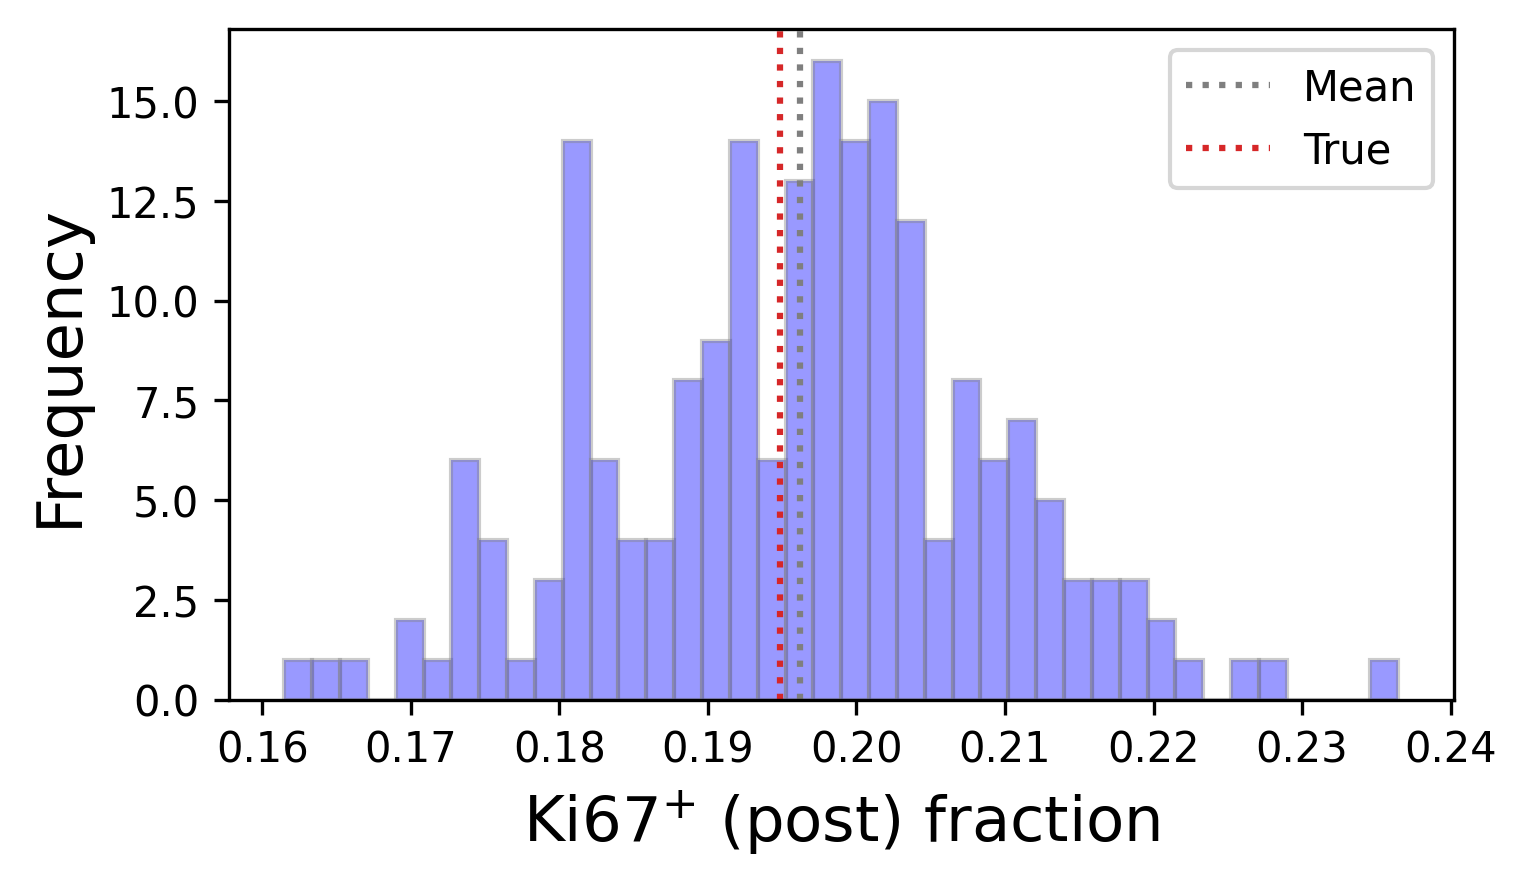

In [20]:
if cycle_model == 0:
    plot_distribution(Ki67_negative_fraction[:,-1], Ki67_negative_true[-1], r"Ki67$^{-}$ fraction", "Ki67_neg_frac")
    plot_distribution(Ki67_positive_premitotic_fraction[:,-1], Ki67_positive_premitotic_true[-1], r"Ki67$^{+}$ (pre) fraction", "Ki67_pos_pre_frac")
    plot_distribution(Ki67_positive_postmitotic_fraction[:,-1], Ki67_positive_postmitotic_true[-1], r"Ki67$^{+}$ (post) fraction", "Ki67_pos_post_frac")
elif cycle_model == 1:
    plot_distribution(Ki67_negative_fraction[:,-1], Ki67_negative_true[-1], r"Ki67$^{-}$ fraction", "Ki67_neg_frac")
    plot_distribution(Ki67_positive_fraction[:,-1], Ki67_positive_true[-1], r"Ki67$^{+}$ fraction", "Ki67_pos_frac")
elif cycle_model == 2:
    plot_distribution(G0G1_phase_fraction[:,-1], G0G1_phase_true[-1], r"G0/G1 fraction", "G0G1_phase_frac")
    plot_distribution(S_phase_fraction[:,-1], S_phase_true[-1], r"S fraction", "S_phase_frac")
    plot_distribution(G2M_phase_fraction[:,-1], G2M_phase_true[-1], r"G2/M fraction", "G2M_phase_frac")
elif cycle_model == 5:
    plot_distribution(live_fraction[:,-1], live_true[-1], r"Live fraction", "Live_frac")
elif cycle_model == 6:
    plot_distribution(G0G1_phase_fraction[:,-1], G0G1_phase_true[-1], r"G0/G1 fraction", "G0G1_phase_frac")
    plot_distribution(S_phase_fraction[:,-1], S_phase_true[-1], r"S fraction", "S_phase_frac")
    plot_distribution(G2_phase_fraction[:,-1], G2_phase_true[-1], r"G2 fraction", "G2_phase_frac")
    plot_distribution(M_phase_fraction[:,-1], M_phase_true[-1], r"M fraction", "M_phase_frac")
else:
    print("Unrecognized cell cycle model.")